In [2]:
%matplotlib inline


# Class Averaging

We demonstrate class averaging using the rotationally invariant representation algorithm.


In [5]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage

from aspire.classification import RIRClass2D, TopClassSelector
from aspire.image import Image
from aspire.noise import WhiteNoiseAdder
from aspire.source import ArrayImageSource  # Helpful hint if you want to BYO array.
from aspire.utils import gaussian_2d
from aspire.basis import FSPCABasis, SteerableBasis2D

logger = logging.getLogger(__name__)

## Build Simulated Data



### Circular 2D Gaussian Image



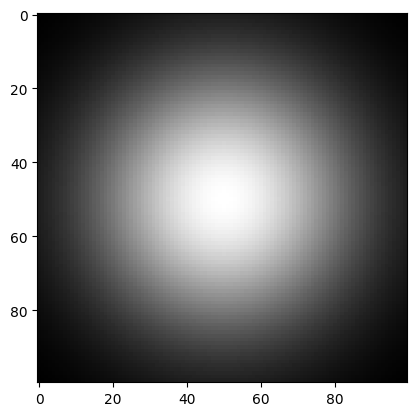

In [4]:
L = 100
round_disc = gaussian_2d(L, sigma=L / 4)
plt.imshow(round_disc, cmap="gray")
plt.show()

### Oval 2D Gaussian Image



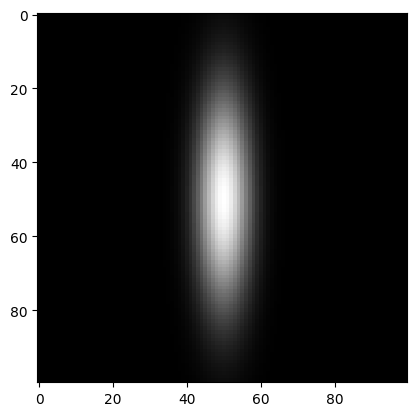

In [5]:
oval_disc = gaussian_2d(L, sigma=(L / 20, L / 5))
plt.imshow(oval_disc, cmap="gray")
plt.show()

### Handed Image

Create richer test set by including an asymmetric image.



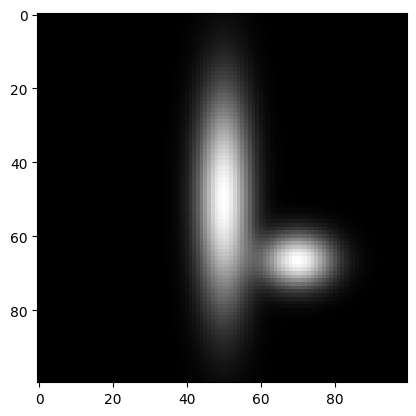

In [6]:
# Create a second oval.
oval_disc2 = gaussian_2d(L, mu=(L / 5, L / 6), sigma=(L / 15, L / 20))

# Strategically add it to `oval_disc`.
yoval_discL = oval_disc.copy()
yoval_discL += oval_disc2
plt.imshow(yoval_discL, cmap="gray")
plt.show()

### Reflected Image

Also include the reflection of  the asymmetric image.



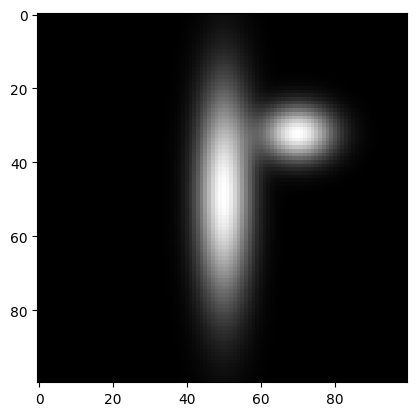

In [7]:
yoval_discR = np.flipud(yoval_discL)
plt.imshow(yoval_discR, cmap="gray")
plt.show()

### Example Data Set Source

We concatenate and shuffle 512 rotations of the Gaussian images above to create our data set.



2023-02-19 16:40:43,369 INFO [aspire.source.image] Attempting to create an Image object from Numpy array.
2023-02-19 16:40:43,371 INFO [aspire.source.image] Creating ArrayImageSource with 1440 images.


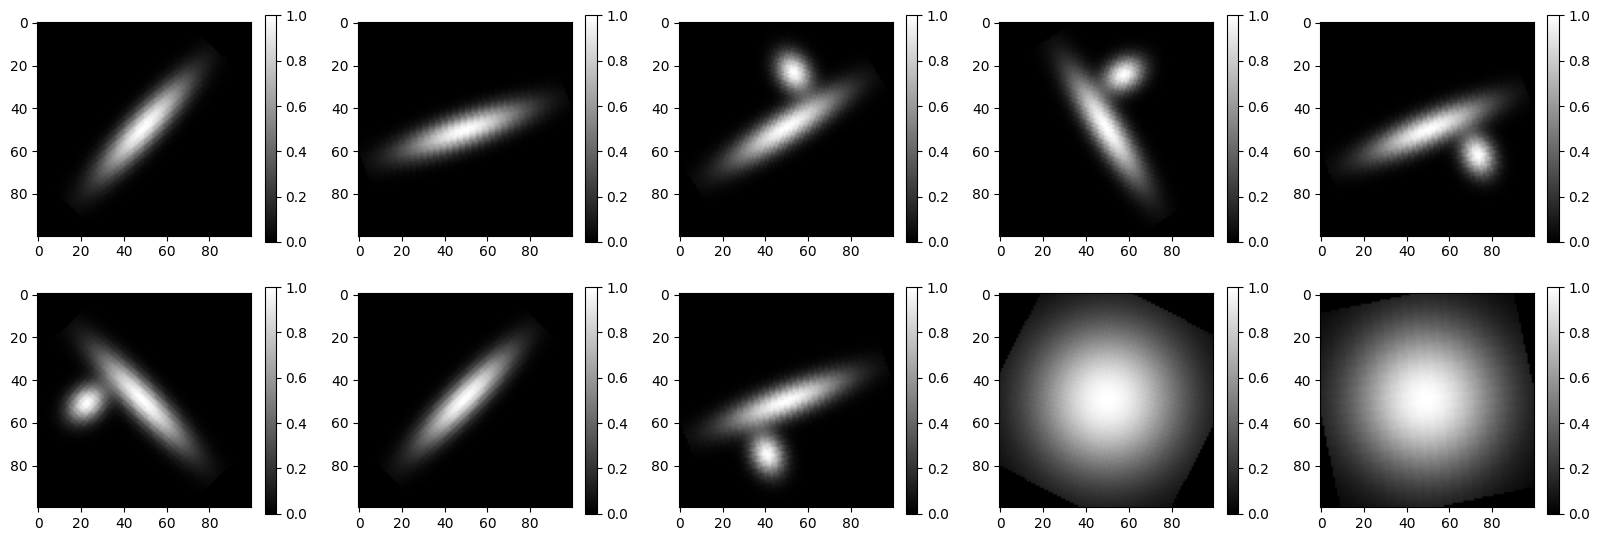

In [ ]:
# How many entries (angles) in our stack
N = 360
thetas = np.linspace(start=0, stop=360, num=N, endpoint=False)

classRound = np.zeros((N, L, L))
classOval = np.zeros((N, L, L))
classYOvalL = np.zeros((N, L, L))
classYOvalR = np.zeros((N, L, L))

for i, theta in enumerate(thetas):
    classRound[i] = np.asarray(PILImage.fromarray(round_disc).rotate(theta))
    classOval[i] = np.asarray(PILImage.fromarray(oval_disc).rotate(theta))
    classYOvalL[i] = np.asarray(PILImage.fromarray(yoval_discL).rotate(theta))
    classYOvalR[i] = np.asarray(PILImage.fromarray(yoval_discR).rotate(theta))

# We'll make an example data set by concatentating then shuffling these.
example_array = np.concatenate((classRound, classOval, classYOvalL, classYOvalR))
np.random.seed(1234567)
np.random.shuffle(example_array)

# So now that we have cooked up an example dataset, lets create an ASPIRE source
src = ArrayImageSource(example_array)

# Let's peek at the images to make sure they're shuffled up nicely
src.images[:10].show()

## Mini Tests

In [6]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage

from aspire.classification import RIRClass2D, TopClassSelector
from aspire.image import Image
from aspire.noise import WhiteNoiseAdder
from aspire.source import ArrayImageSource  # Helpful hint if you want to BYO array.
from aspire.utils import gaussian_2d
from aspire.basis import FSPCABasis, SteerableBasis2D

logger = logging.getLogger(__name__)
L = 100
round_disc = gaussian_2d(L, sigma=L / 4)
oval_disc = gaussian_2d(L, sigma=(L / 20, L / 5))
# Create a second oval.
oval_disc2 = gaussian_2d(L, mu=(L / 5, L / 6), sigma=(L / 15, L / 20))

# Strategically add it to `oval_disc`.
yoval_discL = oval_disc.copy()
yoval_discL += oval_disc2
yoval_discR = np.flipud(yoval_discL)
# How many entries (angles) in our stack
N = 60
thetas = np.linspace(start=0, stop=360, num=N, endpoint=False)

classRound = np.zeros((N, L, L))
classOval = np.zeros((N, L, L))
classYOvalL = np.zeros((N, L, L))
classYOvalR = np.zeros((N, L, L))

for i, theta in enumerate(thetas):
    classRound[i] = np.asarray(PILImage.fromarray(round_disc).rotate(theta))
    classOval[i] = np.asarray(PILImage.fromarray(oval_disc).rotate(theta))
    classYOvalL[i] = np.asarray(PILImage.fromarray(yoval_discL).rotate(theta))
    classYOvalR[i] = np.asarray(PILImage.fromarray(yoval_discR).rotate(theta))

# We'll make an example data set by concatentating then shuffling these.
example_array = np.concatenate((classRound, classOval, classYOvalL, classYOvalR))
np.random.seed(1234567)
np.random.shuffle(example_array)

# So now that we have cooked up an example dataset, lets create an ASPIRE source
src = ArrayImageSource(example_array)

2023-03-06 16:47:10,629 INFO [aspire.source.image] Attempting to create an Image object from Numpy array.
2023-03-06 16:47:10,658 INFO [aspire.source.image] Creating ArrayImageSource with 240 images.


In [7]:
import logging
logger = logging.getLogger()
logger.disabled = True

basis = FSPCABasis(src, components=400, batch_size=512)

2023-03-06 16:47:12,158 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-06 16:47:13,548 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-06 16:47:13,550 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 1/1 [00:00<00:00, 11.93it/s]

2023-03-06 16:47:13,645 INFO [aspire.noise.noise] Noise variance = 0.0011720735853221233
2023-03-06 16:47:13,647 INFO [aspire.basis.fspca] Setting noise_var=0.0011720735853221233
2023-03-06 16:47:13,649 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis


2023-03-06 16:47:16,621 WARNING [aspire.covariance.covar2d] Left side b after removing noise in Batched Cov2D is not positive semidefinite.
2023-03-06 16:47:16,782 WARNING [aspire.covariance.covar2d] Covariance matrix in Batched Cov2D is not positive semidefinite.
2023-03-06 16:47:16,784 INFO [aspire.covariance.covar2d] Convert matrices to positive semidefinite.


In [ ]:
fspca_coef = basis.spca_coef
complex_coef = basis.to_complex(fspca_coef)

In [4]:
coef_shape = np.shape(complex_coef)
orig_coef_shape = np.shape(fspca_coef)
num_images = coef_shape[0]
num_coef = coef_shape[1]

num_images


240

In [5]:

template_bank = basis.generate_random_templates(8*num_coef)
select_bank = basis.select_random_templates(complex_coef, 8*num_coef)

In [7]:
print(np.shape(template_bank))
print(select_bank.shape)
single = template_bank[0]
imm = complex_coef[0]

np.shape(single)

basis.max_filter_companion(single,imm)

(3200, 400)
(3200, 400)


-1.3578060170961541

In [1]:
# testing max filtering - phase retrival
from aspire.basis import SteerableBasis2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline    


b = SteerableBasis2D([10,10])
z = np.array([1,3j], dtype=complex)
w = np.array([1,1], dtype=complex)
b.k_max = 4
b.fixed_angular_indices = {}
b.fixed_angular_indices[2] = [0]
b.fixed_angular_indices[4] = [1]
maxval = b.max_filter_companion(z,w)
maxval


3.72677996249965

In [2]:
b.max_filter_fft(z,w, 400)

3.7267779194329167

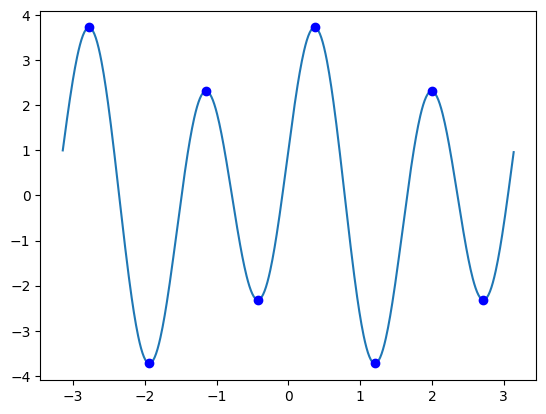

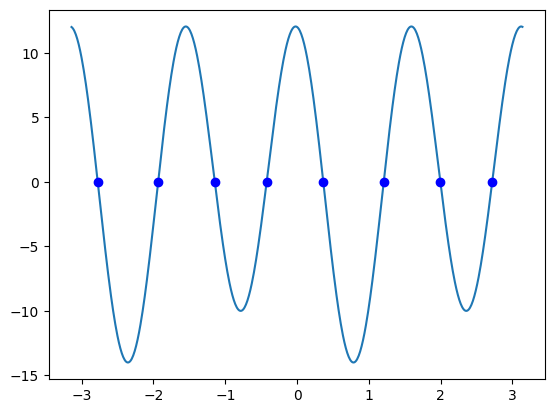

In [ ]:
x = np.arange(-np.pi,np.pi,0.01)   # start,stop,step
y = np.real( np.exp(1j*2*x) - 3*1j*np.exp(1j*4*x) )
der = np.real(1j*2*np.exp(1j*2*x) - 1j*4*3*1j*np.exp(1j*4*x))
derargs = np.real(1j*2*np.exp(1j*2*args) - 1j*4*3*1j*np.exp(1j*4*args))
points = np.real( np.exp(1j*2*args) - 3*1j*np.exp(1j*4*args) )
plt.plot(x,y)
plt.plot(args, points, 'bo')
plt.show()
plt.plot(x,der)
plt.plot(args,derargs,'bo')
plt.show()

In [ ]:
from scipy.optimize import minimize_scalar

def temp_fn(x):
    return -np.real( np.exp(1j*2*x) - 3*1j*np.exp(1j*4*x) )

res = minimize_scalar(temp_fn, method='bounded', bounds=(0, 2*np.pi))
-res.fun

3.72677996249039

## Max Filter Classifier Test

In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage

from aspire.classification import RIRClass2D, TopClassSelector
from aspire.image import Image
from aspire.noise import WhiteNoiseAdder
from aspire.source import ArrayImageSource  # Helpful hint if you want to BYO array.
from aspire.utils import gaussian_2d
from aspire.basis import FSPCABasis, SteerableBasis2D

logger = logging.getLogger(__name__)
L = 100
round_disc = gaussian_2d(L, sigma=L / 4)
oval_disc = gaussian_2d(L, sigma=(L / 20, L / 5))
# Create a second oval.
oval_disc2 = gaussian_2d(L, mu=(L / 5, L / 6), sigma=(L / 15, L / 20))

# Strategically add it to `oval_disc`.
yoval_discL = oval_disc.copy()
yoval_discL += oval_disc2
yoval_discR = np.flipud(yoval_discL)
# How many entries (angles) in our stack
N = 512
thetas = np.linspace(start=0, stop=360, num=N, endpoint=False)

classRound = np.zeros((N, L, L))
classOval = np.zeros((N, L, L))
classYOvalL = np.zeros((N, L, L))
classYOvalR = np.zeros((N, L, L))

for i, theta in enumerate(thetas):
    classRound[i] = np.asarray(PILImage.fromarray(round_disc).rotate(theta))
    classOval[i] = np.asarray(PILImage.fromarray(oval_disc).rotate(theta))
    classYOvalL[i] = np.asarray(PILImage.fromarray(yoval_discL).rotate(theta))
    classYOvalR[i] = np.asarray(PILImage.fromarray(yoval_discR).rotate(theta))

# We'll make an example data set by concatentating then shuffling these.
example_array = np.concatenate((classRound, classOval, classYOvalL, classYOvalR))
np.random.seed(1234567)
np.random.shuffle(example_array)

# So now that we have cooked up an example dataset, lets create an ASPIRE source
src = ArrayImageSource(example_array)

2023-03-03 16:30:03,452 INFO [aspire.source.image] Attempting to create an Image object from Numpy array.
2023-03-03 16:30:03,454 INFO [aspire.source.image] Creating ArrayImageSource with 2048 images.


In [3]:
rir = RIRClass2D(
    src,
    fspca_components=400,
    bispectrum_components=300,  # Compressed Features after last PCA stage.
    n_nbor=10,
    n_classes=10,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    bispectrum_implementation="legacy",
    max_filter = True,
    max_filter_method = "fft",
    max_filter_fft_padding = 300,
    max_filter_template_selection = "random_gaussian",
    num_templates = 300,
    num_procs=1,  # Change to "auto" if your machine has many processors
)

classesmax, reflmax, distancesmax = rir.classify()

2023-03-03 16:32:08,224 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-03 16:32:09,499 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-03 16:32:09,500 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 4/4 [00:00<00:00, 16.19it/s]

2023-03-03 16:32:09,752 INFO [aspire.noise.noise] Noise variance = 0.0011709638958461602
2023-03-03 16:32:09,753 INFO [aspire.basis.fspca] Setting noise_var=0.0011709638958461602
2023-03-03 16:32:09,754 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis


2023-03-03 16:32:29,793 WARNING [aspire.covariance.covar2d] Left side b after removing noise in Batched Cov2D is not positive semidefinite.
2023-03-03 16:32:30,007 WARNING [aspire.covariance.covar2d] Covariance matrix in Batched Cov2D is not positive semidefinite.
2023-03-03 16:32:30,010 INFO [aspire.covariance.covar2d] Convert matrices to positive semidefinite.


100%|██████████| 2048/2048 [01:27<00:00, 23.45it/s]


2023-03-03 16:34:09,573 INFO [aspire.classification.rir_class2d] Calculate Nearest Neighbors using sklearn.


In [20]:
rir = RIRClass2D(
    src,
    fspca_components=400,
    bispectrum_components=300,  # Compressed Features after last PCA stage.
    n_nbor=10,
    n_classes=10,
    large_pca_implementation="legacy",
    nn_implementation="legacy",
    bispectrum_implementation="legacy",
    max_filter = False,
    num_procs=1,  # Change to "auto" if your machine has many processors
)

#classes, dists = rir.classify()
classesbi, refl, distancesbi = rir.classify()

2023-02-25 17:05:34,891 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-02-25 17:05:36,375 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-02-25 17:05:36,376 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 4/4 [00:00<00:00, 11.59it/s]

2023-02-25 17:05:36,726 INFO [aspire.noise.noise] Noise variance = 0.0011709638958461602
2023-02-25 17:05:36,727 INFO [aspire.basis.fspca] Setting noise_var=0.0011709638958461602
2023-02-25 17:05:36,729 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis


2023-02-25 17:06:10,371 WARNING [aspire.covariance.covar2d] Left side b after removing noise in Batched Cov2D is not positive semidefinite.
2023-02-25 17:06:12,526 WARNING [aspire.covariance.covar2d] Covariance matrix in Batched Cov2D is not positive semidefinite.
2023-02-25 17:06:12,530 INFO [aspire.covariance.covar2d] Convert matrices to positive semidefinite.
2023-02-25 17:06:57,727 INFO [aspire.classification.rir_class2d] Calculate Nearest Neighbors using legacy.


100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


In [21]:
avgsbi = rir.averages(classesbi, refl, distancesbi)

2023-02-25 17:06:59,064 INFO [aspire.classification.rir_class2d] Select 10 Classes from Nearest Neighbors
2023-02-25 17:06:59,071 INFO [aspire.classification.rir_class2d] Begin Averaging of 10 Classes using <aspire.classification.averager2d.BFSReddyChatterjiAverager2D object at 0x7f2d1834df70>.


100%|██████████| 10/10 [00:00<00:00, 10.18it/s]

2023-02-25 17:13:18,830 INFO [aspire.source.image] Creating ArrayImageSource with 10 images.


In [5]:
avgsmax = rir.averages(classesmax, reflmax, distancesmax)

2023-03-03 16:34:39,226 INFO [aspire.classification.rir_class2d] Select 10 Classes from Nearest Neighbors
2023-03-03 16:34:39,231 INFO [aspire.classification.rir_class2d] Begin Averaging of 10 Classes using <aspire.classification.averager2d.BFSReddyChatterjiAverager2D object at 0x7f5fcd7b60d0>.


100%|██████████| 10/10 [00:00<00:00, 17.87it/s]


2023-03-03 16:39:20,725 INFO [aspire.source.image] Creating ArrayImageSource with 10 images.


### Display Classes



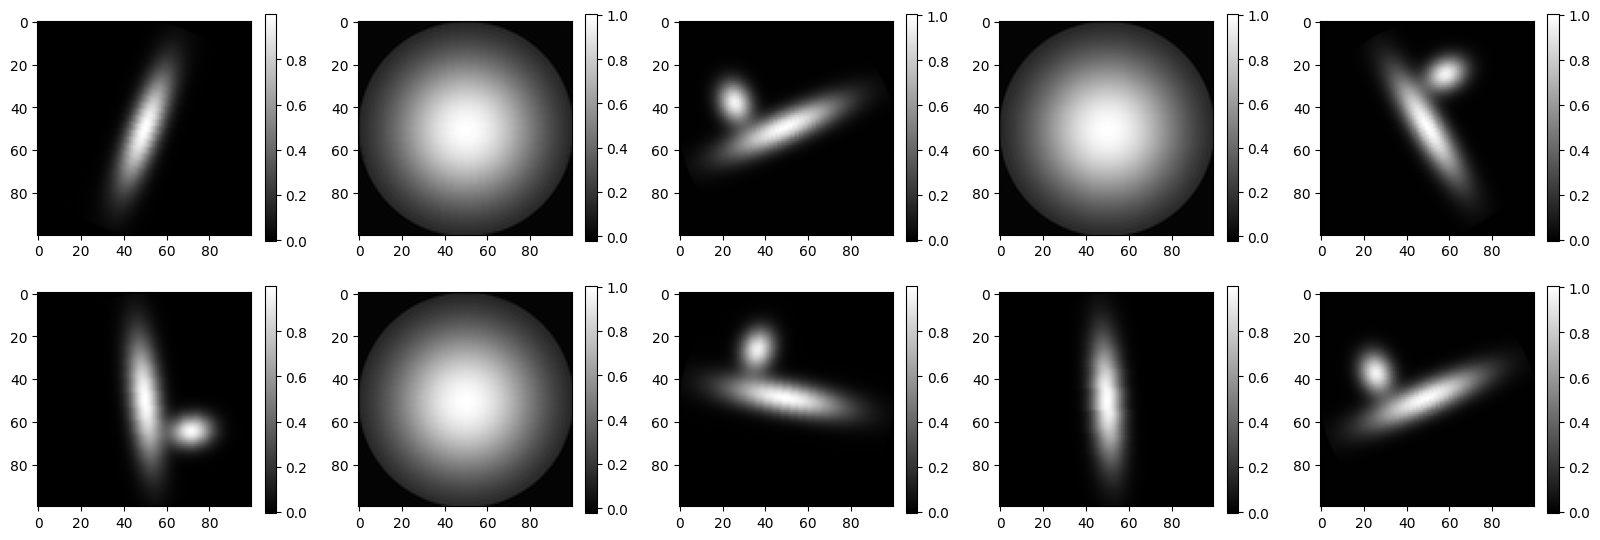

In [7]:
avgsmax.images[:10].show()

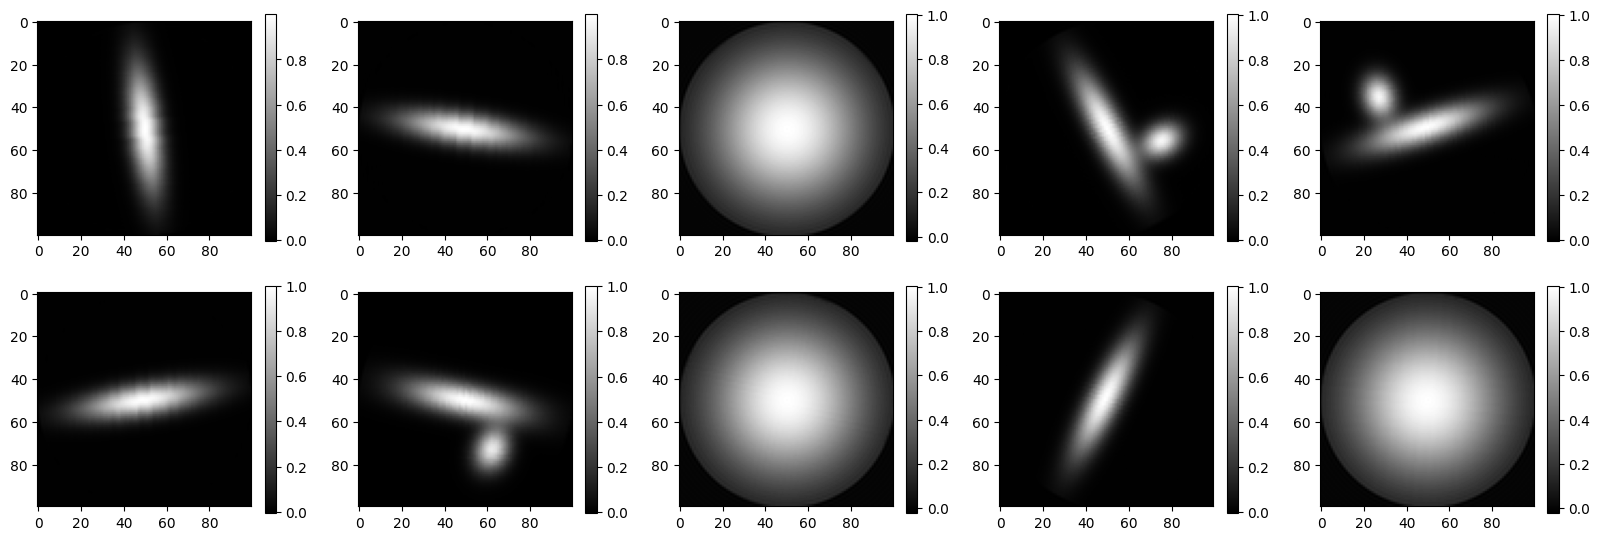

In [24]:
avgsbi.images[:10].show()

## Class Averaging with Noise



### Add Noise to Data Set



2023-03-03 16:40:08,374 INFO [aspire.source.image] Creating ArrayImageSource with 2048 images.


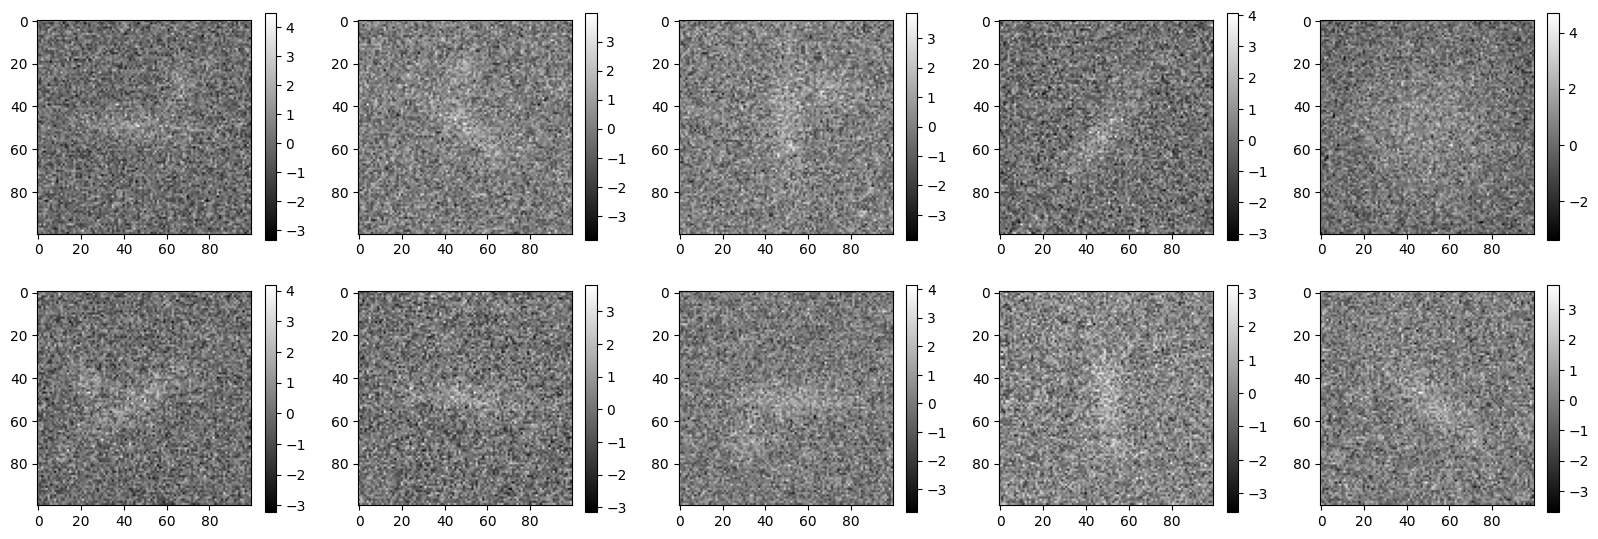

In [8]:
# Using the sample variance, we'll compute a target noise variance
# Noise
var = np.var(src.images[:].asnumpy())
noise_var = var * 2**4

# Then create noise with the ``WhiteNoiseAdder`` class.
noise = WhiteNoiseAdder(var=noise_var, seed=123)

# Add noise to the images by performing ``forward``
noisy_im = noise.forward(src.images[:])

# Recast as an ASPIRE source
noisy_src = ArrayImageSource(noisy_im)

# Let's peek at the noisey images
noisy_src.images[:10].show()

### RIR with Noise
This also demonstrates changing the Nearest Neighbor search to using
scikit-learn, and using ``TopClassSelector``.``TopClassSelector``
will deterministically select the first ``n_classes``.  This is useful
for development and debugging.  By default ``RIRClass2D`` uses a
``RandomClassSelector``.



In [11]:
noisy_rir_max = RIRClass2D(
    noisy_src,
    fspca_components=400,
    bispectrum_components=300,
    n_nbor=10,
    n_classes=10,
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    max_filter=True,
    max_filter_method="fft",
    max_filter_fft_padding = 400,
    max_filter_template_selection = "random_source",
    bispectrum_implementation="legacy",
    num_templates = 300,
    num_procs=1,  # Change to "auto" if your machine has many processors
)

classes_max, reflections_max, dists_max = noisy_rir_max.classify()
avgs_max = noisy_rir_max.averages(classes_max, reflections_max, dists_max)

2023-03-03 16:50:48,110 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-03 16:50:49,261 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-03 16:50:49,263 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 4/4 [00:00<00:00, 11.68it/s]

2023-03-03 16:50:49,615 INFO [aspire.noise.noise] Noise variance = 0.9117873916386763
2023-03-03 16:50:49,616 INFO [aspire.basis.fspca] Setting noise_var=0.9117873916386763
2023-03-03 16:50:49,616 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis


2023-03-03 16:51:06,752 WARNING [aspire.covariance.covar2d] Left side b after removing noise in Batched Cov2D is not positive semidefinite.
2023-03-03 16:51:07,233 WARNING [aspire.covariance.covar2d] Covariance matrix in Batched Cov2D is not positive semidefinite.
2023-03-03 16:51:07,236 INFO [aspire.covariance.covar2d] Convert matrices to positive semidefinite.


100%|██████████| 2048/2048 [01:07<00:00, 30.53it/s]


2023-03-03 16:52:27,600 INFO [aspire.classification.rir_class2d] Calculate Nearest Neighbors using sklearn.
2023-03-03 16:52:27,865 INFO [aspire.classification.rir_class2d] Select 10 Classes from Nearest Neighbors
2023-03-03 16:52:27,868 INFO [aspire.classification.rir_class2d] Begin Averaging of 10 Classes using <aspire.classification.averager2d.BFSReddyChatterjiAverager2D object at 0x7f5fb9e1a940>.


100%|██████████| 10/10 [00:00<00:00, 20.15it/s]


2023-03-03 16:57:07,426 INFO [aspire.source.image] Creating ArrayImageSource with 10 images.


In [12]:
noisy_rir_bi = RIRClass2D(
    noisy_src,
    fspca_components=400,
    bispectrum_components=300,
    n_nbor=10,
    n_classes=10,
    selector=TopClassSelector(),
    large_pca_implementation="legacy",
    nn_implementation="sklearn",
    max_filter= False,
    bispectrum_implementation="legacy",
    num_procs=1,  # Change to "auto" if your machine has many processors
)

classes_bi, reflections_bi, dists_bi = noisy_rir_bi.classify()
avgs_bi = noisy_rir_bi.averages(classes_bi, reflections_bi, dists_bi)

2023-03-03 16:00:42,882 INFO [aspire.basis.ffb_2d] Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2023-03-03 16:00:43,969 INFO [aspire.basis.fspca] Estimating the noise of images.
2023-03-03 16:00:43,970 INFO [aspire.noise.noise] Determining Noise variance in batches of 512


100%|██████████| 4/4 [00:00<00:00, 12.30it/s]

2023-03-03 16:00:44,298 INFO [aspire.noise.noise] Noise variance = 0.9117873916386763
2023-03-03 16:00:44,300 INFO [aspire.basis.fspca] Setting noise_var=0.9117873916386763
2023-03-03 16:00:44,301 INFO [aspire.covariance.covar2d] Represent CTF filters in FB basis


2023-03-03 16:01:02,536 WARNING [aspire.covariance.covar2d] Left side b after removing noise in Batched Cov2D is not positive semidefinite.
2023-03-03 16:01:03,095 WARNING [aspire.covariance.covar2d] Covariance matrix in Batched Cov2D is not positive semidefinite.
2023-03-03 16:01:03,096 INFO [aspire.covariance.covar2d] Convert matrices to positive semidefinite.
2023-03-03 16:01:18,777 INFO [aspire.classification.rir_class2d] Calculate Nearest Neighbors using sklearn.
2023-03-03 16:01:18,915 INFO [aspire.classification.rir_class2d] Select 10 Classes from Nearest Neighbors
2023-03-03 16:01:18,918 INFO [aspire.classification.rir_class2d] Begin Averaging of 10 Classes using <aspire.classification.averager2d.BFSReddyChatterjiAverager2D object at 0x7f38f8f0e100>.


100%|██████████| 10/10 [00:00<00:00, 16.67it/s]


2023-03-03 16:06:05,606 INFO [aspire.source.image] Creating ArrayImageSource with 10 images.


### Display Classes



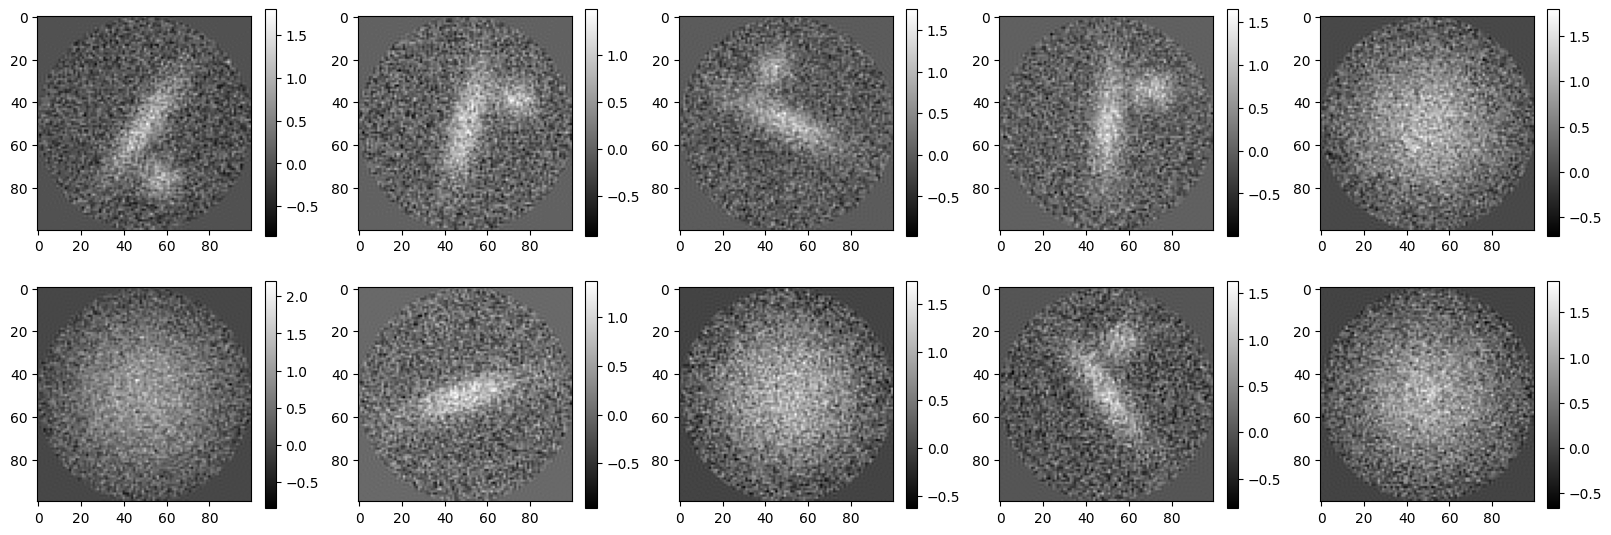

In [12]:
avgs_max.images[:10].show()

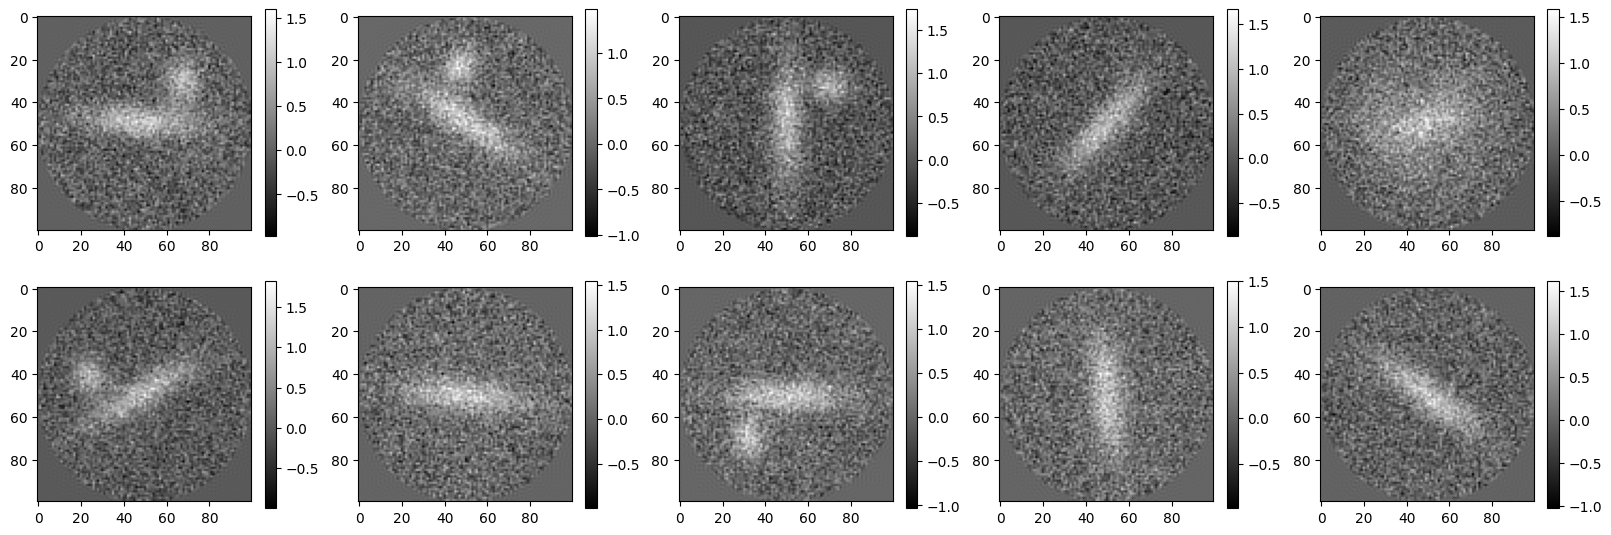

In [13]:
avgs_bi.images[:10].show()

## Review a class

Select a class to review.



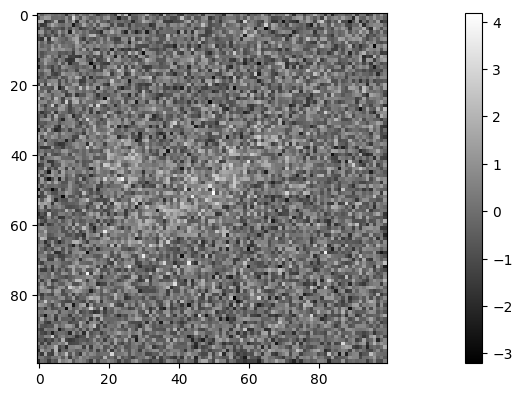

NameError: name 'classes' is not defined

In [30]:
review_class = 5

# Display the original image.
noisy_src.images[review_class].show()

# Report the identified neighbor indices
logger.info(f"Class {review_class}'s neighors: {classes_max[review_class]}")

# Report the identified neighbors
Image(noisy_src.images[:][classes_max[review_class]]).show()

# Display the averaged result
avgs_max.images[review_class].show()

## Alignment Details

Alignment details are exposed when avaialable from an underlying ``averager``.
In this case, we'll get the estimated alignments for the ``review_class``.
These alignment arrays are indexed the same as ``classes``,
having shape (n_classes, n_nbor).



In [ ]:
est_rotations = noisy_rir.averager.rotations[review_class]
est_shifts = noisy_rir.averager.shifts[review_class]
est_correlations = noisy_rir.averager.correlations[review_class]

logger.info(f"Estimated Rotations: {est_rotations}")
logger.info(f"Estimated Shifts: {est_shifts}")
logger.info(f"Estimated Correlations: {est_correlations}")

# Compare the original unaligned images with the estimated alignment.
# Get the indices from the classification results.
nbr = 3
original_img_0_idx = classes[review_class][0]
original_img_nbr_idx = classes[review_class][nbr]

# Lookup the images.
original_img_0 = noisy_src.images[original_img_0_idx].asnumpy()[0]
original_img_nbr = noisy_src.images[original_img_nbr_idx].asnumpy()[0]

# Rotate using estimated rotations.
angle = est_rotations[nbr] * 180 / np.pi
if reflections[review_class][nbr]:
    original_img_nbr = np.flipud(original_img_nbr)
rotated_img_nbr = np.asarray(PILImage.fromarray(original_img_nbr).rotate(angle))

plt.subplot(2, 2, 1)
plt.title("Original Images")
plt.imshow(original_img_0)
plt.xlabel("Img 0")
plt.subplot(2, 2, 2)
plt.imshow(original_img_nbr)
plt.xlabel(f"Img {nbr}")

plt.subplot(2, 2, 3)
plt.title("Est Rotation Applied")
plt.imshow(original_img_0)
plt.xlabel("Img 0")
plt.subplot(2, 2, 4)
plt.imshow(rotated_img_nbr)
plt.xlabel(f"Img {nbr} rotated {angle:.4}*")
plt.tight_layout()
plt.show()